In [310]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

In [287]:
df = pd.read_csv('Financial Distress.csv')
print("Length of Financial Distress Column",len(df['Financial Distress'].unique()))
print("Total missing values:", df.isna().sum().sum())
print('Total Time Period in dataset',df['Time'].sum())
# df.set_index('Time', inplace=True)
df.head()

Length of Financial Distress Column 3610
Total missing values: 0
Total Time Period in dataset 27644


,Company,Time,Financial Distress,x1,x2,x3,x4,x5,x6,x7,...,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
0,1,1,0.010636,1.2810,0.022934,0.87454,1.21640,0.060940,0.188270,0.52510,...,85.437,27.07,26.102,16.000,16.0,0.2,22,0.060390,30,49
1,1,2,-0.455970,1.2700,0.006454,0.82067,1.00490,-0.014080,0.181040,0.62288,...,107.090,31.31,30.194,17.000,16.0,0.4,22,0.010636,31,50
2,1,3,-0.325390,1.0529,-0.059379,0.92242,0.72926,0.020476,0.044865,0.43292,...,120.870,36.07,35.273,17.000,15.0,-0.2,22,-0.455970,32,51
3,1,4,-0.566570,1.1131,-0.015229,0.85888,0.80974,0.076037,0.091033,0.67546,...,54.806,39.80,38.377,17.167,16.0,5.6,22,-0.325390,33,52
4,2,1,1.357300,1.0623,0.107020,0.81460,0.83593,0.199960,0.047800,0.74200,...,85.437,27.07,26.102,16.000,16.0,0.2,29,1.251000,7,27


In [288]:
df["Financial Distress"] = (df["Financial Distress"] <= 0.5).astype(int)
target_col = 'Financial Distress'
X = df.drop(columns=[target_col])
y = df['Financial Distress']
print('Total Distress Companies in the dataset',y.sum())
print('Total Companies', len(X['Company'].unique()))

Total Distress Companies in the dataset 1670
Total Companies 422


### PCA of Financial Features with Distress Labels

In [289]:
# Grouping the Dataset with the Companies (1-44) and claculating it's mean , std, min and max for each feature
grouped_df = X.groupby('Company').agg(['mean', 'std', 'min', 'max'])
grouped_df.columns = ['_'.join(col) for col in grouped_df.columns]  
grouped_df = grouped_df.fillna(grouped_df.mean())
grouped_df.reset_index(inplace=True)
grouped_df.head()

,Company,Time_mean,Time_std,Time_min,Time_max,x1_mean,x1_std,x1_min,x1_max,x2_mean,...,x81_min,x81_max,x82_mean,x82_std,x82_min,x82_max,x83_mean,x83_std,x83_min,x83_max
0,1,2.5,1.290994,1,4,1.179250,0.113913,1.05290,1.2810,-0.011305,...,-0.455970,0.06039,31.5,1.290994,30,33,50.5,1.290994,49,52
1,2,7.5,4.183300,1,14,1.539892,0.433811,0.97059,2.2263,0.204816,...,0.007188,2.94130,13.5,4.183300,7,20,33.5,4.183300,27,40
2,3,1.0,2.858475,1,1,0.874400,0.503836,0.87440,0.8744,-0.034676,...,-0.303170,-0.30317,8.0,2.858475,8,8,37.0,2.858475,37,37
3,4,7.5,4.183300,1,14,1.553275,0.637822,0.83537,3.1096,0.138410,...,0.000183,1.81180,34.5,4.183300,28,41,50.5,4.183300,44,57
4,5,7.5,4.183300,1,14,1.127500,0.068102,1.02430,1.2163,0.107643,...,0.003823,6.47060,18.5,4.183300,12,25,43.5,4.183300,37,50


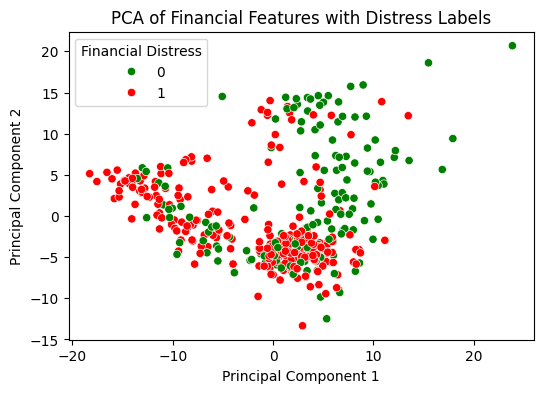

In [306]:
# scaling the data to avoid biasness of one feature 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(grouped_df.drop(columns=['Company']))

# Performing PCA on the financial features with distress labels
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
grouped_df['PCA1'] = X_pca[:, 0]
grouped_df['PCA2'] = X_pca[:, 1]
grouped_df['Financial Distress'] = df.groupby('Company')['Financial Distress'].first().values

plt.figure(figsize=(6, 4))
sns.scatterplot(x='PCA1', y='PCA2', hue='Financial Distress', data=grouped_df, palette=['green', 'red'])
plt.title('PCA of Financial Features with Distress Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Financial Distress')
plt.savefig('pca.png')
plt.show()

### Hardcoding the LDA - Eigen Vectors

In [291]:
X = X.drop(columns=["Company","Time"])
# scaling the data
scaler = StandardScaler()
X_scaler = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
# print(X_scaler.head())
X = X_scaler

In [292]:
# A. Calculating the mean vector of each class
def compute_class_means(X, y):
    classes = np.unique(y)
    mean_vectors = {}
    for c in classes:
        mean_vectors[c] = np.mean(X[y == c], axis=0)
    return mean_vectors

# B.  Calculating the within-class scatter matrix S_w
def compute_within_class_scatter(X, y, mean_vectors):
    n_features = X.shape[1]
    S_w = np.zeros((n_features, n_features))
    for c in mean_vectors:
        class_scatter = np.zeros((n_features, n_features))
        for row in X[y == c].values:  
            row = row.reshape(-1, 1) 
            mean = mean_vectors[c].values.reshape(-1, 1)  
            class_scatter += (row - mean) @ (row - mean).T
        S_w += class_scatter
    return S_w


# C. Calculate the between-class scatter matrix S_b
def compute_between_class_scatter(X, y, mean_vectors):
    overall_mean = np.mean(X.values, axis=0).reshape(-1, 1)
    n_features = X.shape[1]
    S_b = np.zeros((n_features, n_features))
    for c, mean_vec in mean_vectors.items():
        n_samples = X[y == c].shape[0]
        mean_vec = mean_vec.values.reshape(-1, 1)  
        S_b += n_samples * (mean_vec - overall_mean) @ (mean_vec - overall_mean).T
    return S_b


# D. Solve the generalized eigenvalue problem
def lda(X, y, n_components):
    mean_vectors = compute_class_means(X, y)
    S_w = compute_within_class_scatter(X, y, mean_vectors)
    S_b = compute_between_class_scatter(X, y, mean_vectors)
    
    eigvals, eigvecs = np.linalg.eig(np.linalg.inv(S_w) @ S_b)
    eigvals = np.real(eigvals)
    # print('Eigen Values', eigvals)  
    eigvecs = np.real(eigvecs) 
    eigvecs = eigvecs[:, np.argsort(-eigvals)][:, :n_components]
    # print('eigen Vectors', len(eigvecs)) 
    explained_variance_ratio = eigvals / eigvals.sum()
    # print("Explained variance ratio:", explained_variance_ratio)

    return X @ eigvecs 

In [293]:
lda(X, y, n_components=1)

,0
0,0.000215
1,0.000282
2,0.000426
3,0.000147
4,0.000056
...,...
3667,0.000063
3668,0.000055
3669,0.000112
3670,0.000040


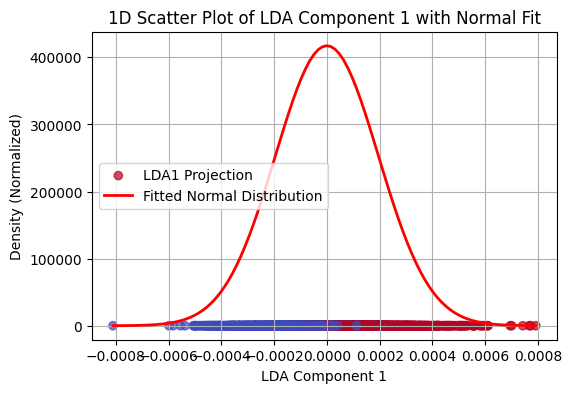

In [294]:
X_lda = lda(X, y, n_components=1).values.flatten()  
mu, sigma = np.mean(X_lda), np.std(X_lda)

x_values = np.linspace(min(X_lda), max(X_lda), 100)
y_values = norm.pdf(x_values, mu, sigma)

plt.figure(figsize=(6, 4))
plt.scatter(X_lda, np.zeros_like(X_lda), c=y, cmap="coolwarm", alpha=0.7, label="LDA1 Projection")
plt.plot(x_values, y_values * max(y_values) * 0.1, 'r-', label="Fitted Normal Distribution", linewidth=2)
plt.xlabel("LDA Component 1")
plt.ylabel("Density (Normalized)")
plt.title("1D Scatter Plot of LDA Component 1 with Normal Fit")
plt.legend()
plt.grid()
plt.savefig('lda3.png')
plt.show()

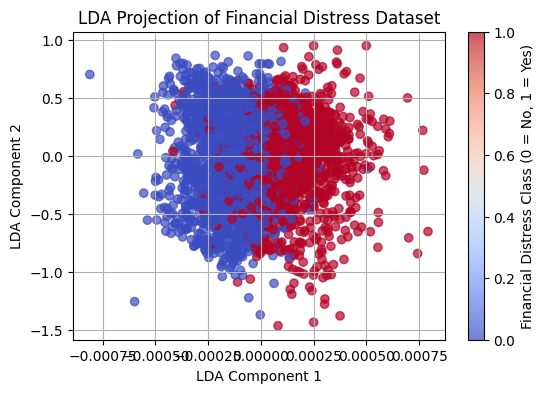

In [308]:
X_lda = lda(X, y, n_components=2) 
X_lda = np.array(X_lda)
plt.figure(figsize=(6, 4))
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y, cmap='coolwarm', alpha=0.7)
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.title("LDA Projection of Financial Distress Dataset")
plt.colorbar(label="Financial Distress Class (0 = No, 1 = Yes)")
plt.grid()
plt.savefig('LDA1.png')
plt.show()

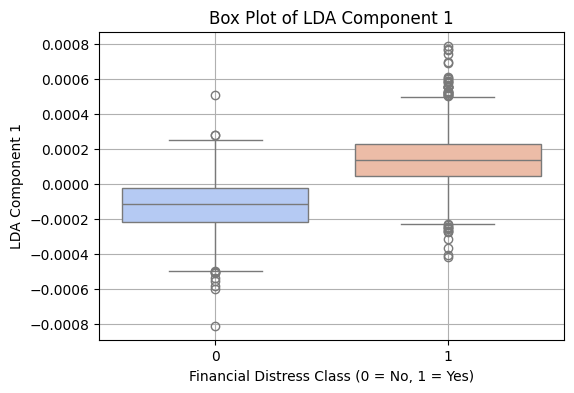

In [307]:
X_lda = lda(X, y, n_components=1).values.flatten() 
df_lda = pd.DataFrame(X_lda, columns=['LDA1'])
df_lda['Class'] = y  

plt.figure(figsize=(6, 4))  
sns.boxplot(x="Class", y="LDA1", data=df_lda, palette="coolwarm")
plt.xlabel("Financial Distress Class (0 = No, 1 = Yes)")
plt.ylabel("LDA Component 1")
plt.title("Box Plot of LDA Component 1")
plt.grid()
plt.savefig('LDA2.png', dpi=300, bbox_inches='tight')  
plt.show()

### Hyperparameter Tunning of LDA

In [299]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
lda_clf = LinearDiscriminantAnalysis()

In [300]:
# Hyperparameter tuning function
def perform_grid_search(parameters, lda_clf, X_train, y_train):
    grid_search = GridSearchCV(lda_clf, parameters, cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)
    
    return grid_search

In [301]:
# 1. Tuning solver
solver_params = {'solver': ['svd', 'lsqr']}
solver_search = perform_grid_search(solver_params, lda_clf, X_train, y_train)

# 2. Tuning shrinkage (only for 'lsqr' solver)
shrinkage_params = {'solver': ['lsqr'], 'shrinkage': [None] + [x / 10 for x in range(0, 11)]}
shrinkage_search = perform_grid_search(shrinkage_params, lda_clf, X_train, y_train)

# 3. Tuning tolerance
tolerance_params = {'tol': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]}
tolerance_search = perform_grid_search(tolerance_params, lda_clf, X_train, y_train)
best_model = tolerance_search.best_estimator_

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'solver': 'svd'}
Best Score: 0.8167315175097276
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'shrinkage': None, 'solver': 'lsqr'}
Best Score: 0.8140077821011673
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best Parameters: {'tol': 0.0001}
Best Score: 0.8167315175097276


In [302]:
# Evaluate on test data
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy of Best Model:", accuracy)

Test Accuracy of Best Model: 0.8257713248638838


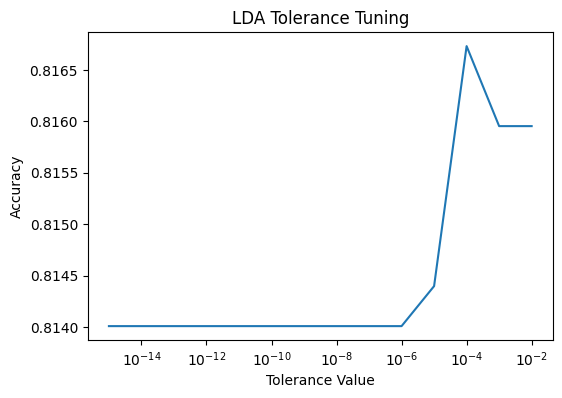

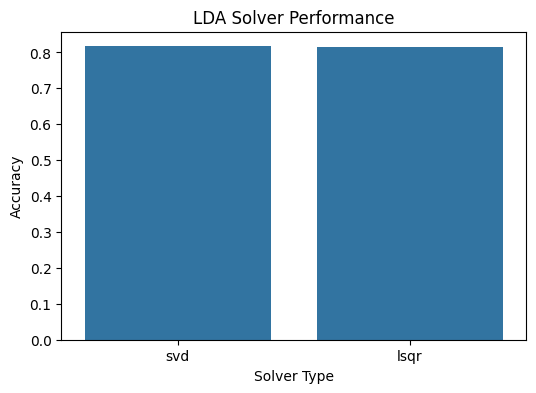

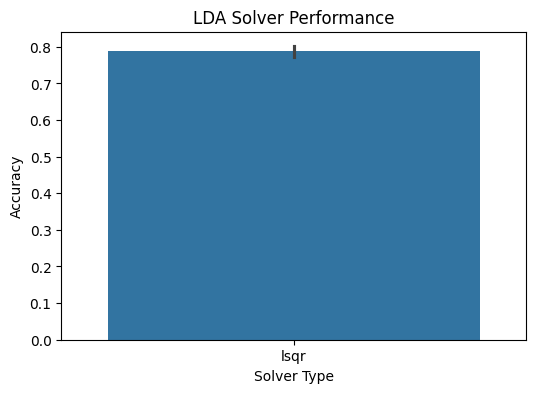

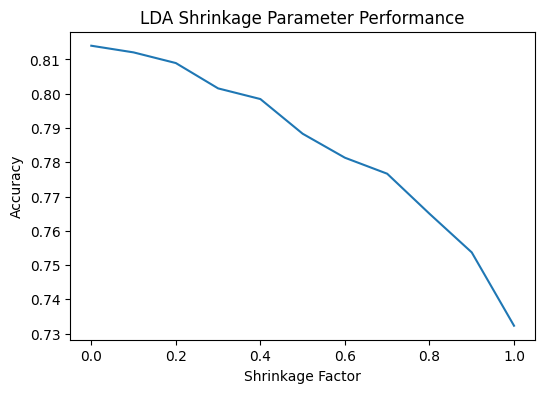

In [305]:
def plot_grid_search(grid_search):
    results = pd.DataFrame(grid_search.cv_results_)
    if 'param_solver' in results.columns:
        plt.figure(figsize=(6, 4))
        sns.barplot(x=results['param_solver'].astype(str), y=results['mean_test_score'])
        plt.xlabel("Solver Type")
        plt.ylabel("Accuracy")
        plt.title("LDA Solver Performance")
        plt.savefig('Solver.png')
        plt.show()
    
    if 'param_shrinkage' in results.columns:
        plt.figure(figsize=(6, 4))
        sns.lineplot(x=results['param_shrinkage'], y=results['mean_test_score'])
        plt.xlabel("Shrinkage Factor")
        plt.ylabel("Accuracy")
        plt.title("LDA Shrinkage Parameter Performance")
        plt.savefig('Shrinkage.png')
        plt.show()
    
    if 'param_tol' in results.columns:
        plt.figure(figsize=(6, 4))
        sns.lineplot(x=results['param_tol'], y=results['mean_test_score'])
        plt.xscale('log')
        plt.xlabel("Tolerance Value")
        plt.ylabel("Accuracy")
        plt.title("LDA Tolerance Tuning")
        plt.savefig('tol.png')
        plt.show()

plot_grid_search(tolerance_search)
plot_grid_search(solver_search)
plot_grid_search(shrinkage_search)

### Evaluation Metrics

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
y_prob = lda.predict_proba(X_test)[:, 1]  # Probability scores for ROC curve

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Explained Variance Ratio
explained_variance = lda.explained_variance_ratio_

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

In [318]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8258
Precision: 0.8086
Recall: 0.7988
F1 Score: 0.8037


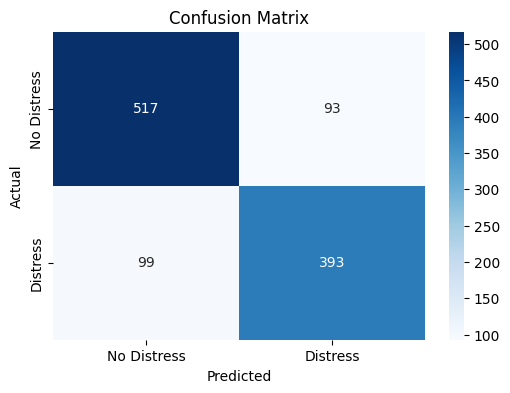

In [315]:
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Distress", "Distress"], 
yticklabels=["No Distress", "Distress"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig('Confusion.png')
plt.show()

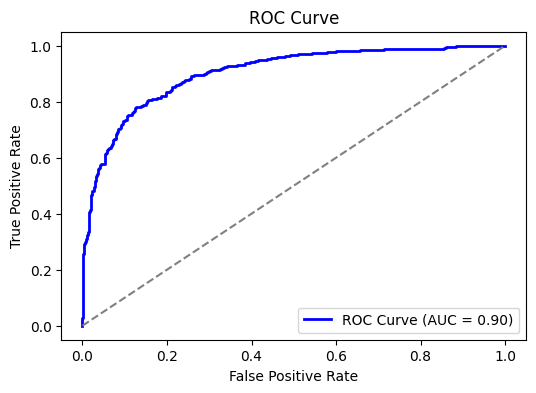

In [317]:
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.savefig('ROC.png')
plt.show()